### Проект по методам оптимизаций 

# The Kernel Trick and its Applications in Machine Learning

## Вступление

Ядерные методы в машинном обучении — это класс алгоритмов распознавания образов, наиболее известным представителем которого является **метод опорных векторов** (**svm**). Общая задача распознавания образов — найти и изучить общие типы связей (например, кластеров, ранжирования, главных компонент, корреляций, классификаций) в наборах данных. Многие алогритмы, решающие эти задачи, преобразуют данные из сырого вида в векторное представление, а ядерные методы требуют лишь задания функции сходства пар точек данных в сыром представлении. 


Ядерные методы получили своё название из-за использования ядерных функций, которые позволяют им оперировать в неявном пространстве признаков высокой размерности без вычисления координат данных в пространстве, просто вычисляя скалярные произведения между образами всех пар данных в пространстве признаков. Эта операция часто вычислительно дешевле явных вычислений координат. Этот подход называется Kernel Trick. Ядерные функции были введены для последовательных данных, графов, текстов, изображений, а также для векторов. 

**Иллюстрация работы алгоритма**

Формула для вычисления предсказания ядерного бинарного классификатора:

$\widehat{y}(x) = sgn\sum\limits_{i=1}^n\omega_i y_i k(x_i, x)$

Здесь

$\widehat{y} \in {-1, 1}$- оценка бинарного классификатора для входа $x$

$k: X \times X \rightarrow \mathbb{R}$

$\{(x_i, y_i)\}_{i=1}^n$ - тренировочная выборка

$\{w_i\}_{i=1}^n$ - параметры классификатора, подбираемые в процессе обучения

## План работы
- тестирование sklearn.svm
- теоретическое обоснование ядерных методов на примере svm
- реализация и анализ работы svm через оптимизацию двойственной задачи
- реализация svm через оптимизацию прямой задачи

In [1]:
from IPython import display
display.display(display.HTML("<style>.container { width:100% !important; }</style>"))

In [145]:
from math import radians, cos, sin, asin, sqrt
import time
import json
from copy import deepcopy
import ast
import warnings
import types

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import load_digits
from sklearn.datasets import make_circles, make_friedman1, make_friedman2, make_friedman3, make_hastie_10_2
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn import svm
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from enum import Enum

## Тестирование sklearn.svm 

**Изучим подробнее метод опорных векторов, как наиболее популярный метод, использующий ядерный трюк**

Прежде всего, заглянем в sklearn и сравним подходы, использующие ядерный метод с другими моделями, решающими аналогичные задачи. 

Сравнение произведем на классической задаче многоклассовой классификации - определение цифры, изображенной на картинке.

In [8]:
digits = load_digits()

In [9]:
def plot_digit(digit, ax):
    ax.imshow(digit, cmap=plt.cm.gray_r, interpolation='nearest')

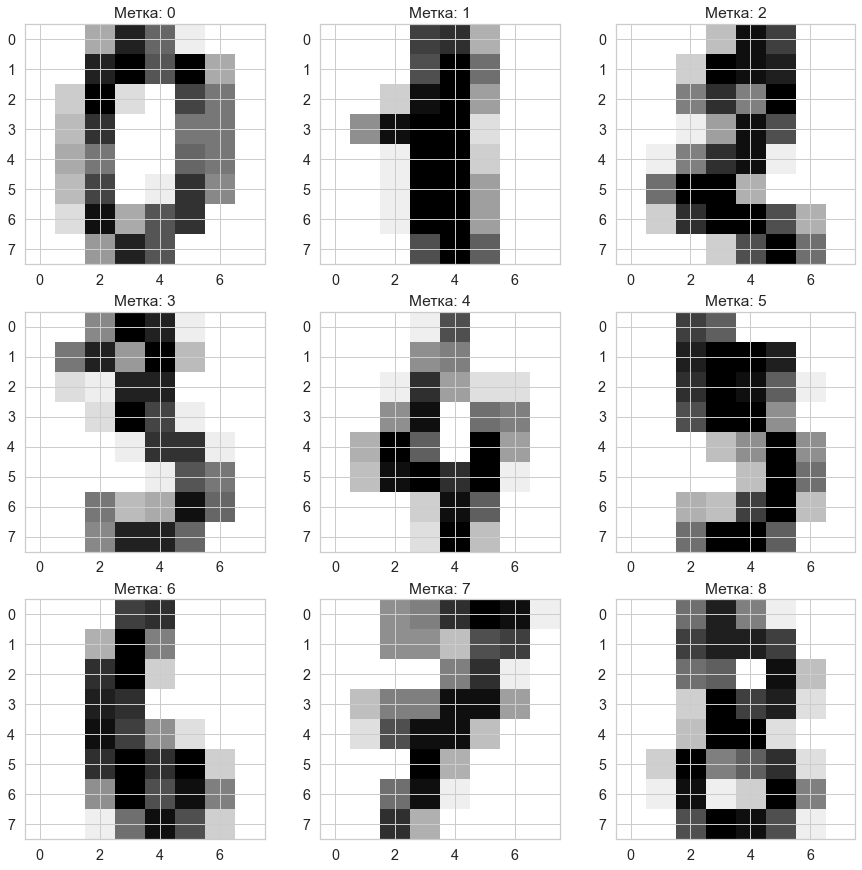

In [10]:
k = 3
_, axes = plt.subplots(k, k, figsize=(k * 5, k * 5))

for i in range(k):
    for j in range(k):
        ax = axes[i][j]
        idx = i * k + j
        plot_digit(digits['data'][idx].reshape(8, 8), ax)
        ax.set_title(f'Метка: {digits.target[idx]}')

plt.show()

In [45]:
X = normalize(digits.data)
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [176]:
def test_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_test_predicted = model.predict(X_test)
    result = accuracy_score(y_test, y_test_predicted)
    return result

In [64]:
models_to_test = {
    'svm': svm.SVC(decision_function_shape="ovo", random_state=42),
    'random_forest': RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42),
    'logistic_regression': LogisticRegression(random_state=42),
    'naive_bayes': MultinomialNB(),
    'KNeighborsClassifier': KNeighborsClassifier()
}

for model_name in models_to_test:
    model_to_test = models_to_test[model_name]
    print(f'Точность {model_name}: {test_model(X_train, X_test, y_train, y_test, model_to_test)}')

Точность svm: 0.9833101529902643
Точность random_forest: 0.9318497913769124
Точность logistic_regression: 0.9360222531293463
Точность naive_bayes: 0.9123783031988874
Точность KNeighborsClassifier: 0.9763560500695411


Как видим, SVM, реализованный в sklearn лучше всех из рассмотренных моделей справился с задачей многоклассовой классификации (точность около 0.9833 на тестовой выборке из стандартного набора датасета с цифрами из sklearn.datasets)

Теперь сравним между собой различные ядра в SVM, примененные к этой же задаче

In [179]:
kernels_to_test = ['linear', 'poly', 'rbf']

models_to_test = {
    f'svm ({kernel})': svm.SVC(kernel=kernel) for kernel in kernels_to_test
}

for model_name in models_to_test:
    model_to_test = models_to_test[model_name]
    print(f'Точность {model_name}: {test_model(X_train, X_test, y_train, y_test, model_to_test)}')

Точность svm (linear): 0.9666203059805285
Точность svm (poly): 0.9847009735744089
Точность svm (rbf): 0.9833101529902643


Все ядра позволяют добиваться высокой точности, но в случае poly и rbf качество предсказаний лучше, таким образом, в этой задаче переход в пространство более высокой размерности помогает улучшить качество модели, а, значит, ядерный трюк стоит более детального изучения.

## Теоретическая часть

### Метод опорных векторов

**Постановка задачи**

Дано:
Обучающая выборка $X^l = (x_i, y_i)_{i=1}^{l}$

$x_i$ - объекты, векторы из множества $X = R^n$

$y_i$ - метки классов, элементы множества $Y = \{-1, +1\}$

$sign(\langle x, w \rangle - w_0)$

Критерий - минимизация эмпирического риска: $\sum_{i=1}^{l}[M_i(w, w_0) < 0] \rightarrow min_{w, w_0}$, где $M_i(w, w_0) = (\langle x_i, w \rangle - w_0)y_i$ - отступ (margin) объекта $x_i$

Аппроксимация + регуляризация - один из способов прийти к SVM

**Идея метода**

Основная идея метода опорных векторов заключается в переводе исходных векторов в пространство более высокой размерности, в котором ищется разделяющая гиперплоскость с наибольшим зазором в этом пространстве. Одно из немедленных преимуществ такого подхода наглядность и интуитивность.

Пример линейно раделимой выборки и оптимальной разделяющей прямой:

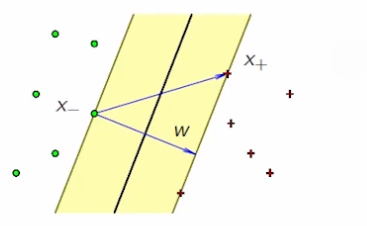

### Покажем, как к постановке формальной задачи SVM можно придти из общих логических соображений.

**Понятие оптимальной разделяющей гиперплоскости**

Пусть выборка линейно разделима. 

$\exists w, w_0$ такие, что $M_i(w, w_0) = y_i(\langle w_, x_i \rangle - w_0) > 0$, $i = 1, ..., l$

Производим нормировку, чтобы коэффициенты модели не уходили в бесконечность $min_{i = 1,...l} M_i(w, w_0) = 1$

Разделяющая плоскость $\{x: -1 \leq \langle w, x \rangle - w_0 \leq 1\}$

Хотим максимизировать ширину полосы. Своими краями полоса упрется в объекты обучающей выборки (Найдутся точки на границе полосы с $\langle w, x_{\pm} \rangle - w_0 = \pm 1$), отсюда получаем следующую формулу

Ширина полосы $h = \dfrac{\langle x_+ - x_i, w \rangle}{||w||} = \dfrac{2}{||w||} \rightarrow max$

Итак, для случая линейно разделимой выборки:
    
$
\begin{cases}
  \frac{1}{2}||w||^2\rightarrow min_{w, w_0}\\
  M_i(w, w_0) \geq 1, i=1,...,l
\end{cases}\,
$

Система, к которой мы приходим в общем случае (когда система неравенств может быть несовместна):

$
\begin{cases}
  \frac{1}{2}||w||^2 + С\sum_{i=1}^l \xi_i \rightarrow min_{w, w_0, \xi_i}\\
  M_i(w, w_0) \geq 1 - \xi_i, i=1,...,l \\
  \xi_i \geq 0
\end{cases}\,
$

Здесь $\xi_i$ соответствует штрафу за неправильное определение класса для элемента $i$

Путем некоторых хитрых преобразований получаем эквивалентную задачу минимизации:

$C \sum_{i=1}^l(1-M_i(w, w_0))_+ + \frac{1}{2}||w||^2 \rightarrow min_{w, w_0}$

То есть, SVM - аппроксимация и регуляризация эмпирического риска.

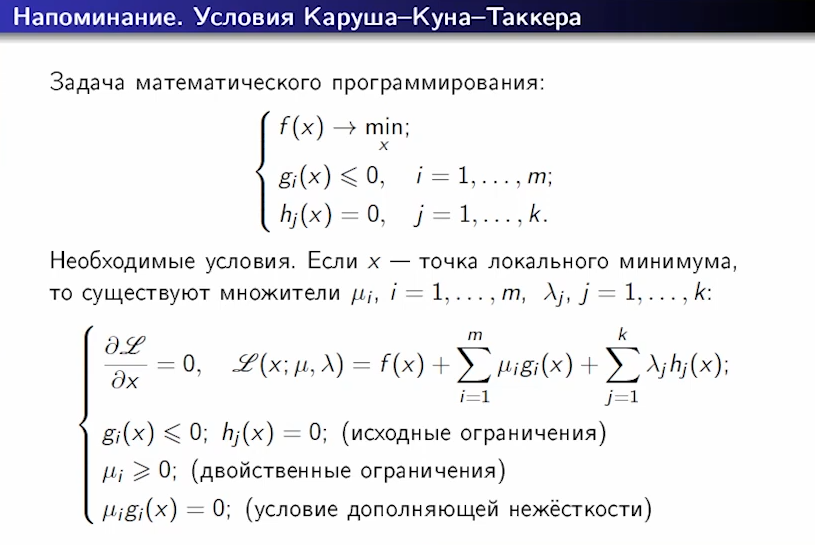

Функция Лагранжа: $L(w, w_0, \xi, \lambda, \eta) = \frac{1}{2}||w||^2 - \sum_{i=1}^{l}\lambda_i(M_i(w,w_0)-1) - \sum_{i=1}^{l}\xi_i(\lambda_i + \eta_i - C)$

Необходимые условия седловой точки функции Лагранжа

$\dfrac{\partial L}{\partial w} = w - \sum_{i=1}^l \lambda_i y_i x_i = 0 \Rightarrow w = \sum_{i=1}^l \lambda_i y_i x_i$ - линейная комбинация объектов обучающей выборки

$\lambda_i = 0$ означает, что решение задачи от этого элемента выборки не зависит. Остальные векторы называются опорными.

$\dfrac{\partial L}{\partial w_0} = -\sum_{i=1}^{l} \lambda_i y_i = 0 \Rightarrow \sum_{i=1}^{l} \lambda_i y_i = 0$

$\dfrac{\partial L}{\partial \xi_i} = -\lambda_i - \eta_i + C = 0 \Rightarrow \eta_i + \lambda_i = C, i = 1,...,l$ 

Объекты делятся на 3 типа:
- $\lambda_i = 0, \eta_i = C, \xi_i = 0, M_i > 1$ - периферийные (неинформативные объекты, глубоко в толще своего класса)
- $0 < \lambda_i < C, 0 \eta_i < C, \xi_i = 0, M_i = 1$ - опорные граничные объекты
- $\lambda_i = C, \eta_i = 0, \xi_i = 0, M_i < 1$ - опорные - нарушители (от 0 до 1 нет ошибки, но мы уже штрафуем)


**Определение** Объект $x_i$ называется опорным, если $\lambda_i \ne 0$

**Замечание** Согласно определению, опорные объекты - не только те, которые определяют полосу, но и те, которые "выскочили" в другой класс.

**Переходим к двойственной задаче**

$
\begin{cases}
  -L(\lambda) = -\sum_{i=1}^{l}\lambda_i + \frac{1}{2}\sum_{i=1}^{l}\sum_{j=1}^{l}\lambda_i \lambda_j y_i y_j \langle x_i, x_j \rangle \rightarrow min_\lambda\\
  0 \leq \lambda_i \leq C, i = 1,...,l\\
  \sum_{i=1}^l \lambda_i y_i = 0
\end{cases}\,
$

Решение прямой задачи выражается через решение двойственной, если нам известны $\lambda_i$, то
    
$
\begin{cases}
  w = \sum_{i=1}^{l}\lambda_i y_i x_i\\
  w_0 = \langle w, x_i \rangle - y_i, \forall i: \lambda_i > 0, M_i = 1
\end{cases}\,
$

(достаточно взять любой из опорных граничных объектов $x_i$)

Итак, мы приходим к линейному классификатору с признаками $f_i(x) = \langle x, x_i \rangle$:

Предсказание для нового элемента $a(x) = sign(\sum_{i=1}^{l}\lambda_i y_i \langle x, x_i \rangle - w_0)$

**Промежуточные выводы**:
- заметим, что скалярные произведения $\langle x, x_i \rangle$ нам нужно знать лишь для опорных объектов
- фактически, скалярное произведение является некоторой функцией близости пары элементов
- таким образом, метод опорных векторов в некотором смысле представляет собой выделение опорных векторов, а затем применение метрического классификатора
- это приводит к идее заменить скалярное произведение какой-то более общей функцией близости

### SVM с ядрами

Идея: заменить $\langle x, x' \rangle$ нелинейной функцией $K(x, x')$

Переход к спрямляющему пространству, как правило, более высокой размерности $\psi: X\rightarrow H$

**Определение** функция $K: X \times X \rightarrow R$ - ядро, если $K(x, x') = \langle \psi(x), \psi(x') \rangle$ при некотором $\psi: X \rightarrow H$, где $H$ - гильбертово пространство

**Теорема 1. Критерий ядерной функции** функция $K(x, x')$ является ядром тогда и только тогда, когда она симметрична и неотрицательно определена:

$
\begin{cases}
  K(x, x') = K(x', x)\\
  \int_X \int_X K(x, x')g(x)g(x')dx dx' \geq 0, \forall g: X \rightarrow R
\end{cases}\,
$

Этой теоремой пользоваться неудобно, поэтому существует

**Теорема 2. Конструктивные методы синтеза ядер**
- $K(x, x') = \langle x, x' \rangle $ - ядро
- константа $K(x, x') = 1$ - ядро
- произведение ядер $K(x, x') = K_1(x, x')K_2(x, x')$ - ядро
- $\forall \psi: X \rightarrow R$ произведение $K(x, x') = \psi(x)\psi(x')$ - ядро
- $K(x, x') = \alpha_1 K_1(x, x') + \alpha_2 K_2(x, x')$ при $\alpha_1, \alpha_2 > 0$ - ядро
- $\forall \varphi: X \rightarrow X$ если $K_0$ ядро, то $K(x, x') = K_00(\varphi(x), \varphi(x'))$ - ядро 

**Пример** спрямляющее пространство для квадратичного ядра.

$K(x, x') = \langle x, x' \rangle^2$ - ядро, как произведение двух ядер

$K(u, v) = \langle u, v \rangle^2 = \langle(u_1, u_2), (v_1, v_2)\rangle^2 = (u_1 v_1 + u_2 v_2)^2 = \langle(u_1^2, u_2^2, \sqrt{2}u_1 u_2), (v_1^2, v_2^2, \sqrt{2}v_1 v_2)\rangle$ таким образом, размерность пространства, в котором такое ядро является скалярным произведением, равна 3: $\psi(u_1, u_2) \rightarrow (u_1^2, u_2^2, \sqrt{2}u_1 u_2)$

Разделяющая поверхность в исходном пространстве в этом случае будет полиномом второй степени.

Чтобы получать произвольную полиномиальную поверхность, нужно использовать ядро $K(x, x') = (\langle x, x'\rangle + 1)^d$ - полиномиальное ядро с мономами степени $\leq d$ (является ядром, так как очевидно получается методами синтеза ядер, описанных выше)

**Примеры наиболее популярных ядер:**
- Стандартное ядро $K(x, x') = \langle x, x' \rangle$
- Ядро Фишера $U_x = \nabla_{\theta} log P(x|\theta), K(x, x') = U^T_{x_i}L^{-1}U_{x_j}$ ($L$ - матрица информации Фишера)
- Ядро графа
- Сигмоидное ядро $K(x, x') = tanh(a\langle x, x' \rangle + C)$
- Полиномиальное ядро $K(x, x') = (\sum_{i=1}^n x_i x'_i + c)^n$
- Радиальное ядро (Гауссово) $K(x, x') = exp(-\dfrac{||x - x'||^2}{2\sigma^2})$

**Промежуточные выводы:**
- Используя SVM с произвольным ядром $K$, мы получаем линейный классификатор с признаками $f_i(x) = K(x, x_i)$:
- Класс для нового объекта $x$ определяется как $a(x) = sign(\sum_{i=1}^{l}\lambda_i y_i K(x, x_i) - w_0)$

## Реализация SVM

**Подготовим заранее несколько задач бинарной классификации для тестирования**
- линейно разделимая выборка
- датасет, в котором классы представляют собой вложенные кольца sklearn.datasets.make_circles
- датасет из объектов с 10 признаками sklearn.datasets.make_hastie_10_2 (из документации: y[i] = 1 if np.sum(X[i] ** 2) > 9.34 else -1)

In [219]:
def plot_data(X, y, title, figsize=(12, 8)):
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    plt.title(title, fontsize=18)
    indices_true = (y == 1)
    indices_false = (y == -1)
    if X.shape[1] == 2:
        ax.scatter(X[indices_true, 0], X[indices_true, 1], c='r', label='label = $1$')
        ax.scatter(X[indices_false, 0], X[indices_false, 1], c='b', label='label = $-1$')
    elif X.shape[1] == 3:
        ax = fig.add_subplot(projection='3d')
        ax.scatter(X[indices_true, 0], X[indices_true, 1],  X[indices_true, 2], c='r', label='label = $1$')
        ax.scatter(X[indices_false, 0], X[indices_false, 1], X[indices_false, 2], c='b', label='label = $-1$')
        ax.set_zlabel('feature 2', fontsize=14)
    else:
        raise ValueError('bad X shape in `plot_data`')
    ax.grid(b=True)
    ax.set_xlabel('feature 0', fontsize=14)
    ax.set_ylabel('feature 1', fontsize=14)
    ax.legend(fontsize='xx-large')

In [220]:
def make_linear(n_samples):
    X = sps.uniform(loc=-2, scale=4).rvs(size=(n_samples, 2))
    y = X[:,0] > X[:,1]
    return X, y

In [221]:
X_linear, y_linear = make_linear(n_samples=1000)
X_linear = preprocessing.scale(X_linear)
y_linear = np.where(y_linear == 0, -1, 1)
X_linear_train, X_linear_test, y_linear_train, y_linear_test = train_test_split(X_linear, y_linear, test_size=0.33)

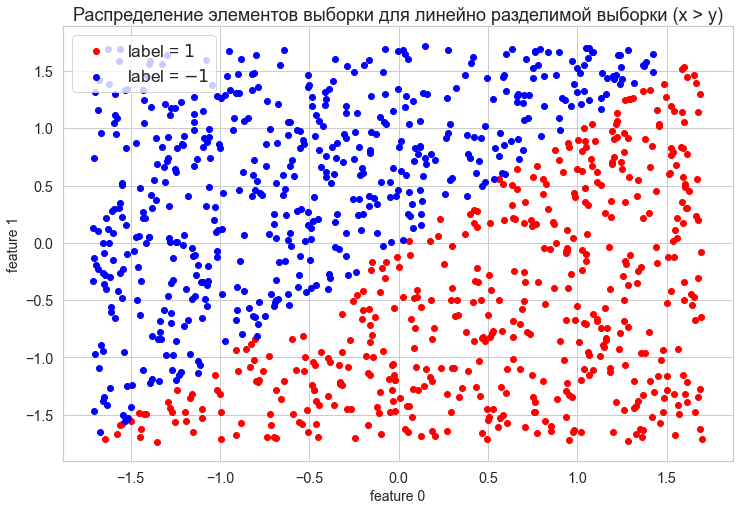

In [222]:
plot_data(X_linear, y_linear, 'Распределение элементов выборки для линейно разделимой выборки (x > y)')

In [223]:
X_circles, y_circles = make_circles(n_samples = 1000, noise = 0.09)
X_circles = preprocessing.scale(X_circles)
y_circles = np.where(y_circles == 0, -1, 1)
X_circles_train, X_circles_test, y_circles_train, y_circles_test = train_test_split(X_circles, y_circles, test_size=0.33, random_state=42)

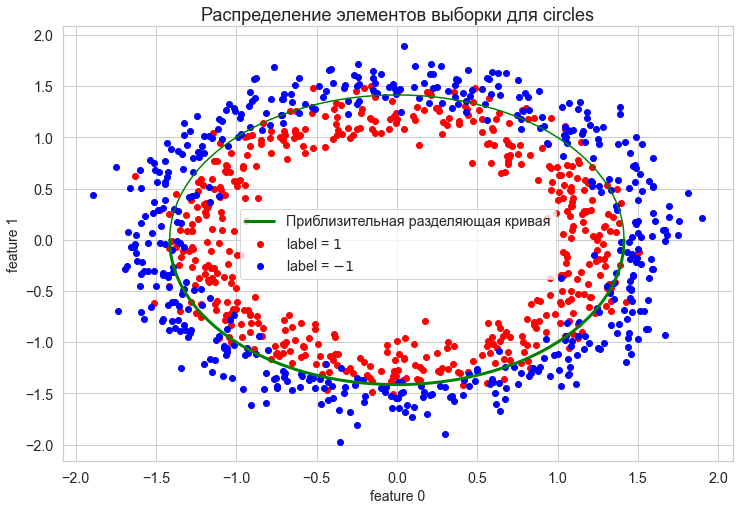

In [224]:
plot_data(X_circles, y_circles, 'Распределение элементов выборки для circles')
r_estimation = 2**0.5
x_grid_tmp = np.linspace(-r_estimation, r_estimation, 1000)
plt.plot(x_grid_tmp, np.sqrt(r_estimation * r_estimation - x_grid_tmp**2), c='g')
plt.plot(x_grid_tmp, -np.sqrt(r_estimation * r_estimation - x_grid_tmp**2), c='g', lw=3, label='Приблизительная разделяющая кривая')
plt.legend()
plt.show()

Посмотрим, как изменится распределение выборки, если использовать упомянутое ранее полиномиальное ядро

$K(u, v) = \langle u, v \rangle^2 = \langle(u_1, u_2), (v_1, v_2)\rangle^2 = (u_1 v_1 + u_2 v_2)^2 = \langle(u_1^2, u_2^2, \sqrt{2}u_1 u_2), (v_1^2, v_2^2, \sqrt{2}v_1 v_2)\rangle$

$\psi(u_1, u_2) \rightarrow (u_1^2, u_2^2, \sqrt{2}u_1 u_2)$

In [225]:
warnings.filterwarnings('ignore')

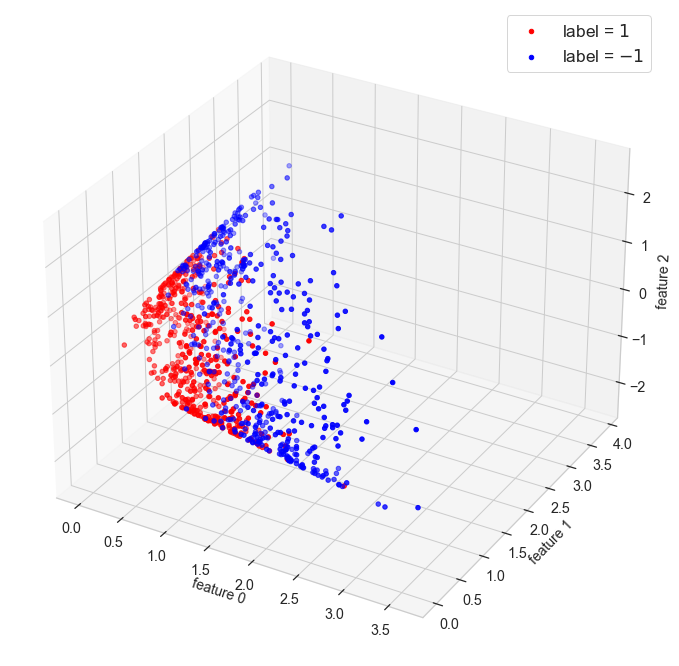

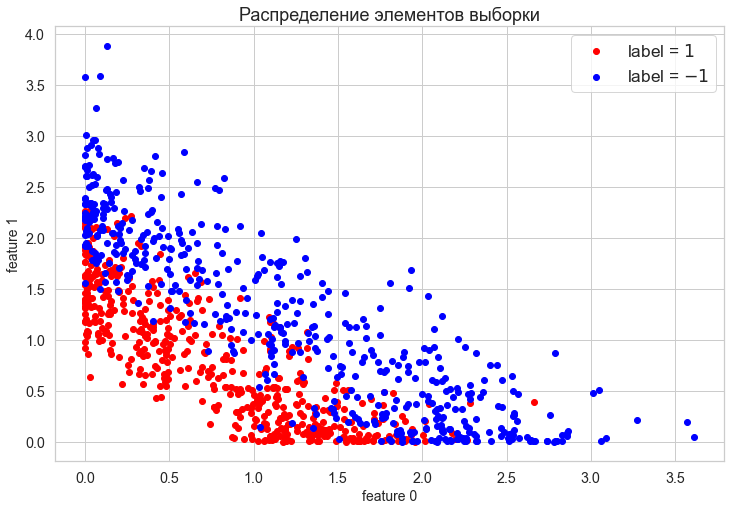

In [226]:
X_poly = np.vstack([X_circles[:, 0]**2, X_circles[:, 1]**2, 2**0.5 * X_circles[:, 0] * X_circles[:, 1]]).T
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y_circles, test_size=0.33, random_state=42)
plot_data(X_poly, y_circles, 'Распределение элементов выборки', figsize=(12, 12))
plot_data(X_poly[:,[0,1]], y_circles, 'Распределение элементов выборки', figsize=(12, 8))

Как видим, в этом пространстве можно гораздо лучше провести разделяющую гиперплоскость.

In [227]:
X_hastie, y_hastie = make_hastie_10_2(n_samples=1000)
X_hastie = preprocessing.scale(X_hastie)
X_train_hastie, X_test_hastie, y_train_hastie, y_test_hastie = train_test_split(X_hastie, y_hastie, test_size=0.33, random_state=42)

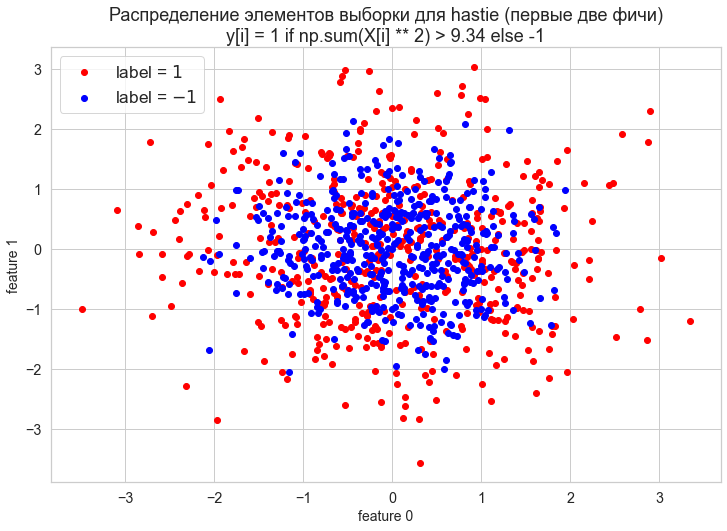

In [228]:
plot_data(X_hastie[:,:2], y_hastie, 'Распределение элементов выборки для hastie (первые две фичи)\n' +
          'y[i] = 1 if np.sum(X[i] ** 2) > 9.34 else -1')

In [229]:
def polynomial_transformer(X):
    result = np.array([X[:, 0]**2, X[:, 1]**2, 2**0.5 * X[:, 0] * X[:, 1], X[:, 0], X[:, 1], [1] * X.shape[0]]).T
    assert(X.shape[0] == result.shape[0])
    return result

def projection(x1, x2):
    # Проекция вектора x1 на вектор x2
    return x2 * np.dot(x1, x2) / np.dot(x2, x2) 

Напомним формулировку двойственной задаче для произвольного ядра $K$:

$
\begin{cases}
  -L(\lambda) = -\sum_{i=1}^{l}\lambda_i + \frac{1}{2}\sum_{i=1}^{l}\sum_{j=1}^{l}\lambda_i \lambda_j y_i y_j K(x_i, x_j) \rightarrow min_\lambda\\
  0 \leq \lambda_i \leq C, i = 1,...,l\\
  \sum_{i=1}^l \lambda_i y_i = 0
\end{cases}\,
$

класс для нового объекта $x$ определяется как $a(x) = sign(\sum_{i=1}^{l}\lambda_i y_i K(x, x_i) - w_0)$

Вооружившись этими знаниями, реализуем SVM

In [230]:
class SupportVectorMachine:
    def __init__(self, data_transformer=None, kernel_name='default', C=1000, lr=1e-2, max_iter=100):
        # Преобразование, применяемое к входным данным перед работой с ними
        self.data_transformer = data_transformer
        
        kernels = {
            'default': SupportVectorMachine.default_kernel,
            'gaussian': SupportVectorMachine.gaussian_kernel,
            'polynomial': SupportVectorMachine.polynomial_kernel
        }
        
        self.kernel = kernels[kernel_name]
        self.C = C
        self.lr = lr
        self.max_iter = max_iter
    
    @staticmethod
    def default_kernel(X1, X2):
        # Просто скалярное произведение
        a = X1 * X2
        assert(a.shape == X1.shape or a.shape == X2.shape)
        if len(a.shape) > 1:
            result = a.sum(axis=1)
        else:
            result = a.sum()
        return result
    
    @staticmethod
    def gaussian_kernel(X1, X2, sigma_sq=0.1):
        # Гауссово ядро
        return np.exp(-((X1 - X2)**2).sum(axis=1) / (2 * sigma_sq))
    
    @staticmethod
    def polynomial_kernel(X1, X2, k=2):
        # Полиномиальное ядро
        result = (SupportVectorMachine.default_kernel(X1, X2) + 1)**k
        return result
    
    @staticmethod
    def f_dual(lambd, X_train, y_train, kernel):
        # я в градиентном спуске функцию не использую, поэтому её реализация мне не нужна
        return None

    @staticmethod
    def f_dual_grad(lambd, X_train, y_train, C, kernel):
        # Градиент оптимизуремого функционала
        result = -np.ones(lambd.shape)
        for i in range(len(result)):
            delta = (y_train[i] * y_train * lambd * kernel(X_train[i], X_train))
            assert(delta.shape == (X_train.shape[0],))
            delta = delta.sum()
            result[i] += delta
        return result
    
    @staticmethod
    def gradient_descent_advanced(f, gradf, lambd0, X_train, y_train, C, kernel, lr, max_iter=1000, tol=1e-8):        
        # Необходимо поддерживать инвариант: значения x0 находятся от 0 до C, sum y_i x_i = 0
        lambd = lambd0.copy()
        lambd -= projection(lambd, y_train)
        iteration = 0
        conv_array = []

        while True:
            alpha = lr / (iteration + 1)
            gradient = gradf(lambd, X_train, y_train, C, kernel)
            lambd = lambd - alpha * gradient
            iteration += 1
            if np.linalg.norm(gradient) < tol:
                break
            if iteration >= max_iter:
                break

            # lambd = np.maximum(lambd, np.zeros(lambd.shape))
            # lambd = np.minimum(lambd, np.ones(lambd.shape) * C)
            lambd -= projection(lambd, y_train)
            lambd = np.maximum(lambd, np.zeros(lambd.shape))
            lambd = np.minimum(lambd, np.ones(lambd.shape) * C)

            assert(lambd.shape == lambd0.shape)
            conv_array.append(lambd)

        conv_array = np.array(conv_array)
        res = {"x": lambd, "num_iter": iteration, "tol": np.linalg.norm(gradient),  "conv_array": np.array(conv_array)}
        return res
    
    @staticmethod
    def get_w0(lambd, X_train, y_train, kernel):
        # Функция выбирает w0, где провести границу раздела между классами
        best_accuracy = 0
        w0 = 0
        for x in X_train:
            assert(lambd.shape == (X_train.shape[0],))
            assert(y_train.shape == (X_train.shape[0],))
            potential_w0 = (kernel(X_train, x) * lambd * y_train).sum()
            score = 0
            for x1, y1 in zip(X_train, y_train):
                y_pred = np.where((kernel(X_train, x1) * lambd * y_train).sum() - potential_w0 < 0, -1, 1)
                if y_pred == y1:
                    score += 1
            accuracy = score / X_train.shape[0]
            if accuracy > best_accuracy:
                w0 = potential_w0
                best_accuracy = accuracy
        return w0
    
    def fit(self, X_train, y_train):
        if self.data_transformer is not None:
            X_train = self.data_transformer(X_train.copy())
        
        self.X_train = X_train
        self.y_train = y_train
        # self.lambd = np.ones(X_train.shape[0]) / X_train.shape[0]
        self.lambd = np.ones(X_train.shape[0]) * self.C / 2
        res = SupportVectorMachine.gradient_descent_advanced(SupportVectorMachine.f_dual, 
                SupportVectorMachine.f_dual_grad, self.lambd, X_train, y_train, self.C, self.kernel, self.lr, max_iter=self.max_iter)
        self.lambd = res['x']
        self.conv_array = res['conv_array']
        self.w0 = SupportVectorMachine.get_w0(self.lambd, self.X_train, self.y_train, self.kernel)
        # print(f'Получившиеся лямбды: (должны быть > 0), {self.lambd}')
        
    def predict(self, x_test, fixed_w0=None):
        # fixed_w0 is needed for debug purposes
        if self.data_transformer is not None:
            x_test = self.data_transformer(x_test)
        
        # x_test - один элемент, для которого нужно определить класс
        assert(self.lambd.shape == (self.X_train.shape[0],))
        assert(self.y_train.shape == (self.X_train.shape[0],))
        if fixed_w0 is None:
            fixed_w0 = self.w0
        result = np.where((self.kernel(self.X_train, x_test) * self.lambd * self.y_train).sum() - fixed_w0 < 0, -1, 1)
        return result
    
    def get_accuracy(self, X_test, y_test):
        score = 0
        for x_test, actual in zip(X_test, y_test):
            pred = self.predict(x_test.reshape(1, -1))
            if pred == actual:
                score += 1
        return round(score / X_test.shape[0], 4)

### Протестируем наш алгоритм на подготовленных ранее данных

In [231]:
def test_model(X_train, y_train, X_test, y_test, x_grid, y_grid, data_transformer=None, 
               kernel_name='default', C=1000, ax=None, max_iter=100, lr=1e-2, plot_convergence=False):
    # графики только для моделей на двумерных данных
    
    # ax - оси для построения графиков
    need_to_show = False
        
    model = SupportVectorMachine(data_transformer, kernel_name, C=C, lr=lr, max_iter=max_iter)
    model.fit(X_train, y_train)
    
    if X_train.shape[1] == 2:
        if ax is None:
            need_to_show = True
            plt.figure(figsize=(12, 8))
            ax = plt.gca()

        for x in x_grid:
            for y in y_grid:
                new_x = np.array([x, y]).reshape(1, -1)
                pred = model.predict(new_x)
                color = 'r' if pred == 1 else 'b'
                ax.scatter(x, y, c=color)

        title = f'kernel_name: {kernel_name}\n' +\
                '1 класс красный, -1 синий\n' +\
                f'Точность на обучающей выборке: {model.get_accuracy(X_train, y_train)}\n' +\
                f'Точность на тестовой выборке: {model.get_accuracy(X_test, y_test)}'
        ax.set_title(title, fontsize=18)
            
        if need_to_show:
            plt.show()
    else:
        print(f'kernel_name: {kernel_name}\n' +\
                f'Точность на обучающей выборке: {model.get_accuracy(X_train, y_train)}\n' +\
                f'Точность на тестовой выборке: {model.get_accuracy(X_test, y_test)}')
    
    if plot_convergence:
        # график сходимости коэффициентов
        plt.figure(figsize=(12, 8))
        conv_array = model.conv_array
        plt.title(f'Сходимость $\\lambda$ в SVM (kernel: {kernel_name})')
        for i in range(min(len(conv_array[0]), 10)):
            plt.plot(np.arange(len(conv_array)), conv_array[:, i], label=f'$\\lambda_j$')
            plt.legend()
        
    return model

### Датасет с кольцами

In [232]:
x_grid = np.linspace(-2, 2, 100)
y_grid = np.linspace(-2, 2, 100)

In [233]:
all_models = []

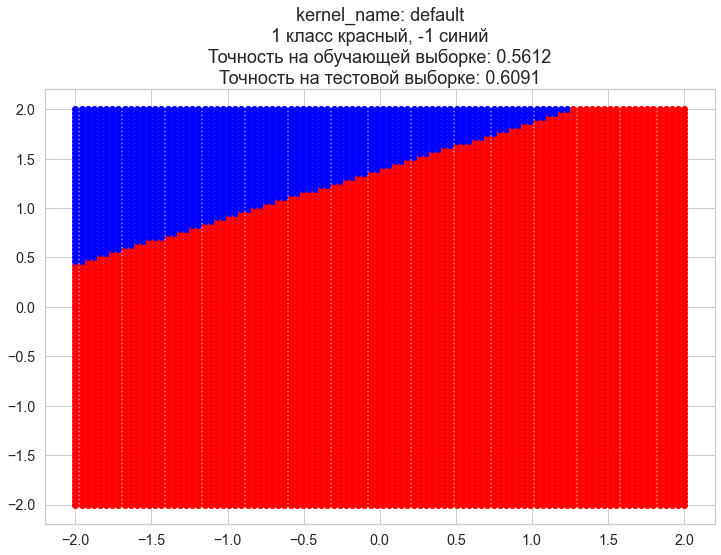

In [234]:
all_models.append({
    'data': 'circles',
    'kernel_name': 'default',
    'model': test_model(X_circles_train, y_circles_train, X_circles_test, y_circles_test, x_grid, y_grid, kernel_name='default', max_iter=1000)
})

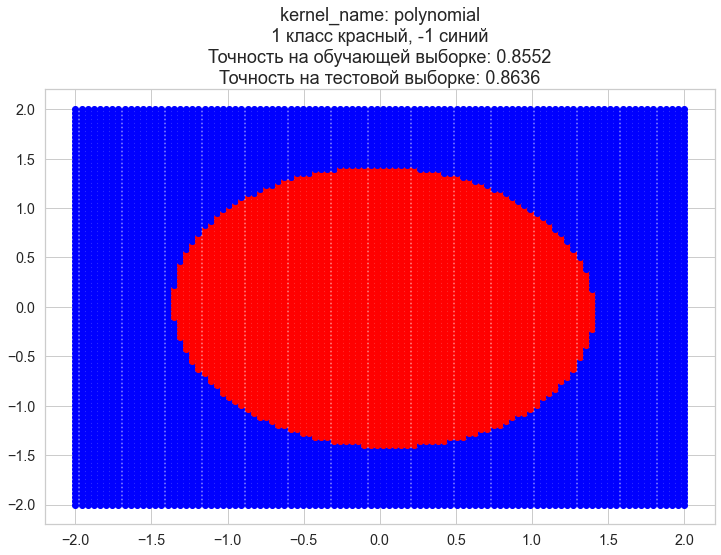

In [235]:
all_models.append({
    'data': 'circles',
    'kernel_name': 'polynomial',
    'model': test_model(X_circles_train, y_circles_train, X_circles_test, y_circles_test, x_grid, y_grid, kernel_name='polynomial', max_iter=1000)
})

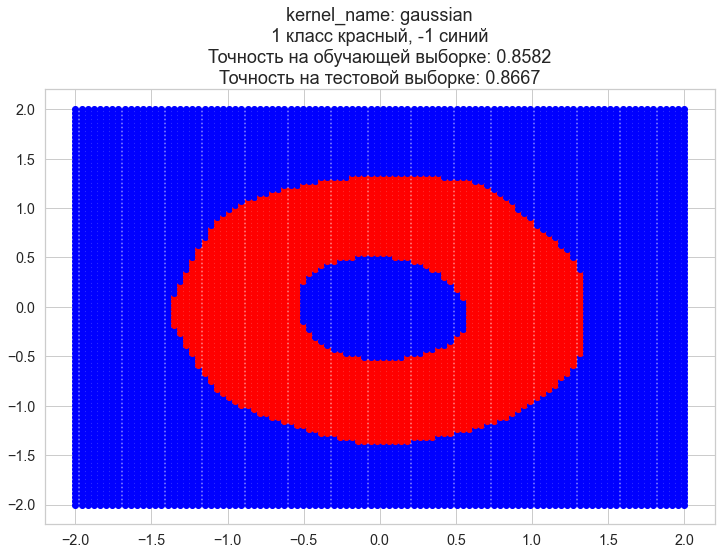

In [236]:
all_models.append({
    'data': 'circles',
    'kernel_name': 'gaussian',
    'model': test_model(X_circles_train, y_circles_train, X_circles_test, y_circles_test, x_grid, y_grid, kernel_name='gaussian', max_iter=1000)
})

#### Обычное ядро в преобразованном пространстве

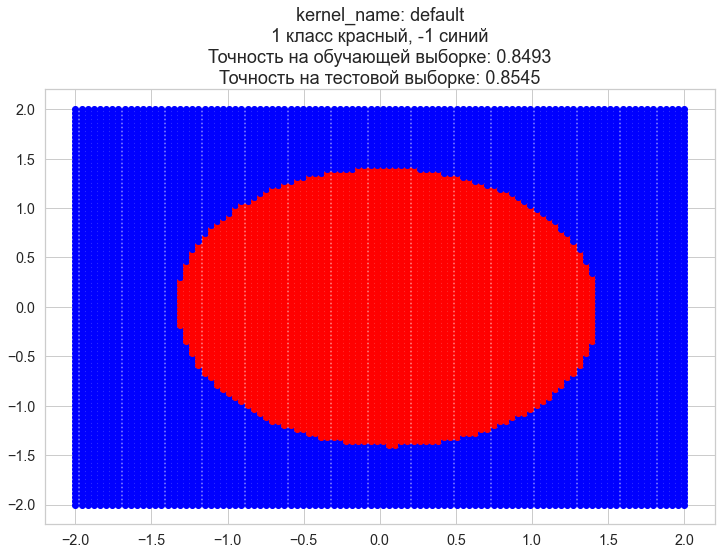

In [237]:
model_circles_transformed = test_model(X_circles_train, y_circles_train, X_circles_test, y_circles_test, x_grid, y_grid,
                   kernel_name='default', lr=1e-2, max_iter=1000, data_transformer=polynomial_transformer)

**Замечание**

такое преобразование данных эквивалентно использованию полиномиального ядра, точности в обоих случаях получились также очень близкими к полиномиальному ядру

### Линейно разделимый датасет

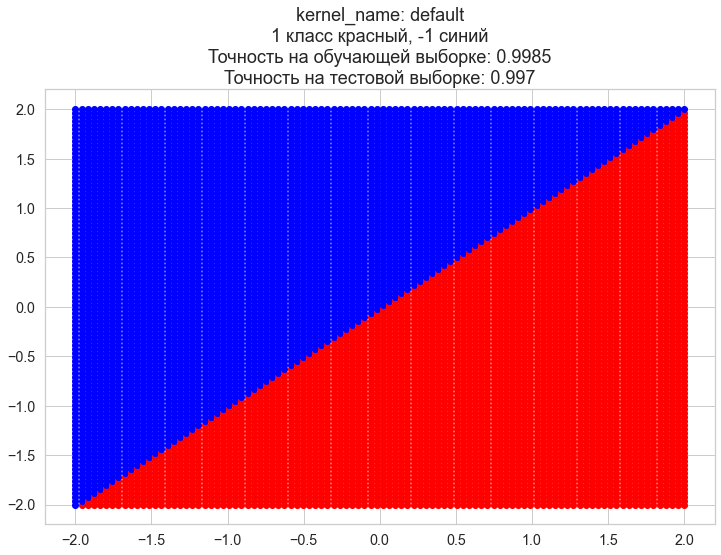

In [238]:
all_models.append({
    'data': 'linear',
    'kernel_name': 'default',
    'model': test_model(X_linear_train, y_linear_train, X_linear_test, y_linear_test, x_grid, y_grid, kernel_name='default', max_iter=1000)
})

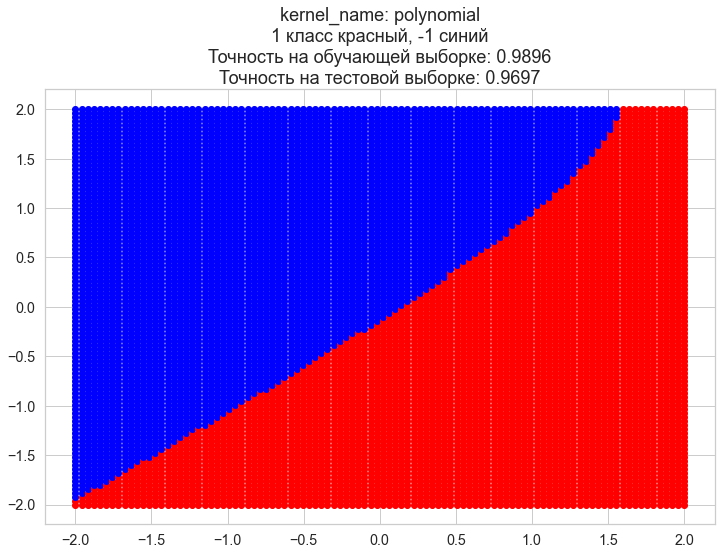

In [239]:
all_models.append({
    'data': 'linear',
    'kernel_name': 'polynomial',
    'model': test_model(X_linear_train, y_linear_train, X_linear_test, y_linear_test, x_grid, y_grid, kernel_name='polynomial', max_iter=1000)
})

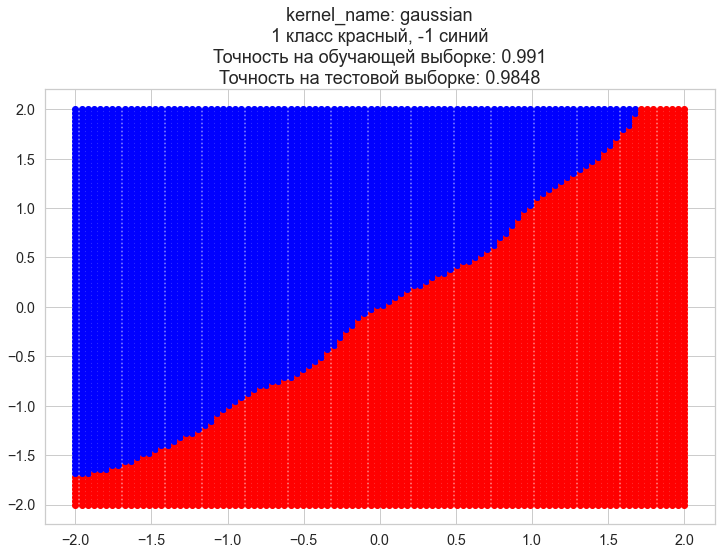

In [240]:
all_models.append({
    'data': 'linear',
    'kernel_name': 'gaussian',
    'model': test_model(X_linear_train, y_linear_train, X_linear_test, y_linear_test, x_grid, y_grid, kernel_name='gaussian', max_iter=1000)
})

###  Датасет с 10 признаками hastie 
(нет визуализации, т.к. 10 признаков, а не 2)

In [241]:
all_models.append({
    'data': 'hastie',
    'kernel_name': 'default',
    'model': test_model(X_train_hastie, y_train_hastie, X_test_hastie, y_test_hastie, x_grid, y_grid, kernel_name='default', max_iter=1000)
})

kernel_name: default
Точность на обучающей выборке: 0.5672
Точность на тестовой выборке: 0.5061


In [242]:
all_models.append({
    'data': 'hastie',
    'kernel_name': 'polynomial',
    'model': test_model(X_train_hastie, y_train_hastie, X_test_hastie, y_test_hastie, x_grid, y_grid, kernel_name='polynomial', max_iter=1000)
})

kernel_name: polynomial
Точность на обучающей выборке: 0.9582
Точность на тестовой выборке: 0.9394


In [243]:
all_models.append({
    'data': 'hastie',
    'kernel_name': 'gaussian',
    'model': test_model(X_train_hastie, y_train_hastie, X_test_hastie, y_test_hastie, x_grid, y_grid, kernel_name='gaussian', max_iter=1000)
})

kernel_name: gaussian
Точность на обучающей выборке: 1.0
Точность на тестовой выборке: 0.5152


**Соберем результаты тестов в одну таблицу:**

|  | Linear | Circles | Hastie |
| --- | --- | --- | --- |
| default | 0.9727 (0.9687) | 0.5636 (0.5746) | 0.5030 (0.5761) |
| polynomial | 0.9970 (0.9970) | 0.8909 (0.8746) | 0.9394 (0.9836) |
| gaussian |  0.9758 (0.9955) | 0.8758 (0.8806) | 0.4636 (1.000) |

**Промежуточные выводы:**

Как видим, результаты в целом получаются достаточно предсказуемыми
- С линейно разделимой выборкой все ядра справились хорошо
- С кольцами обычное ядро не работает (логично, ведь в обычном пространстве признаков классы прямой не разделяются), а гауссово и полиномиальное ядро справились неплохо
- В случае Hastie обычное ядро также не сработало, гауссово переобучилось, это можно объяснить недостаточным размером тренировочной выборки для выделения общих закономерностей
- Полиномиальное ядро с Hastie сработало неплохо - это объясняется тем, как устроены данные в этмо датасете: y[i] = 1 if np.sum(X[i] ** 2) > 9.34 else -1
- Переход в пространство большей размерности [$x_0^2$, $x_1^2$,$x_0 x_1$, $x_0$, $x_1$, $1$] и использование там обычноого ядра дало примерно те же результаты, что полиномиальное ядро

Посмотрим также на сходимость коэффициентов $\lambda_i$ для какой-нибудь конкретной задачи

In [244]:
def classify_element(coef, C):
    eps = 1e-2 * C
    if abs(coef) < eps:
        # lambda_i почти равно 
        return 0
    if abs(coef - C) < eps:
        # lambda_i очень близко к 0
        return 1
    else:
        return 2
    
type_to_name = {
    0: 'Периферийные',
    1: 'Опорные нарушители',
    2: 'Опорные граничные объекты'
}

type_to_color = {
    0: 'r',
    1: 'b',
    2: 'g'
}

In [249]:
def analyze_coefs(data_name, kernel_name):
    model = [experiment for experiment in all_models if experiment['data'] == data_name and experiment['kernel_name'] == kernel_name][-1]['model']

    plt.figure(figsize=(12, 8))
    conv_array = model.conv_array
    plt.title(f'Сходимость $\\lambda$ в SVM (data: {data_name}, kernel: {kernel_name})')
    for i in range(min(len(conv_array[0]), 10)):
        plt.plot(np.arange(len(conv_array)), conv_array[:, i], label=f'$\\lambda_j$')
        plt.legend()
        
    plt.figure(figsize=(12, 8))

    X_train_data = None
    y_train_data = None
    if data_name == 'linear':
        X_train_data = X_linear_train
        y_train_data = y_linear_train
    elif data_name == 'circles':
        plt.plot(x_grid_tmp, np.sqrt(r_estimation * r_estimation - x_grid_tmp**2), c='purple')
        plt.plot(x_grid_tmp, -np.sqrt(r_estimation * r_estimation - x_grid_tmp**2), c='purple', lw=3, label='Реальная приблизительная разделяющая кривая')
        X_train_data = X_circles_train
        y_train_data = y_circles_train
    
    classify_vector = np.array([classify_element(coef, 1000) for coef in conv_array[-1]])
    for number in (0, 1, 2):
        # Оставляем только первый класс для наглядности
        X_filtered = X_train_data[(classify_vector == number) & (y_train_data == 1)]
        plt.scatter(X_filtered[:, 0], X_filtered[:, 1], color=type_to_color[number], label=type_to_name[number])
    plt.ylim(-3, 2)

    plt.legend(fontsize='xx-large')
    plt.show()

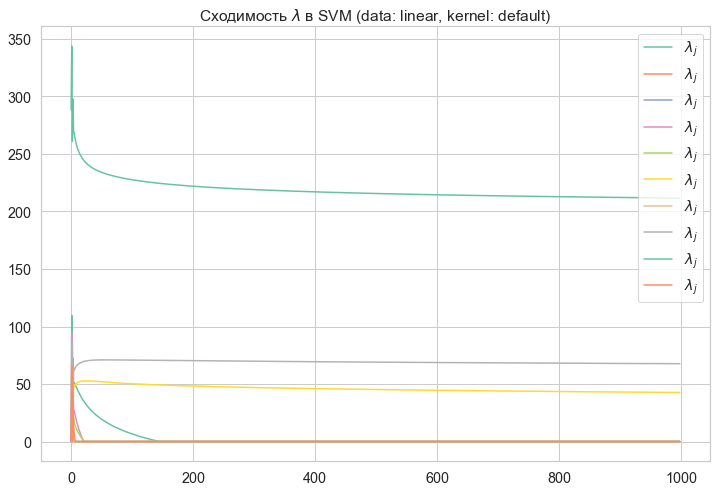

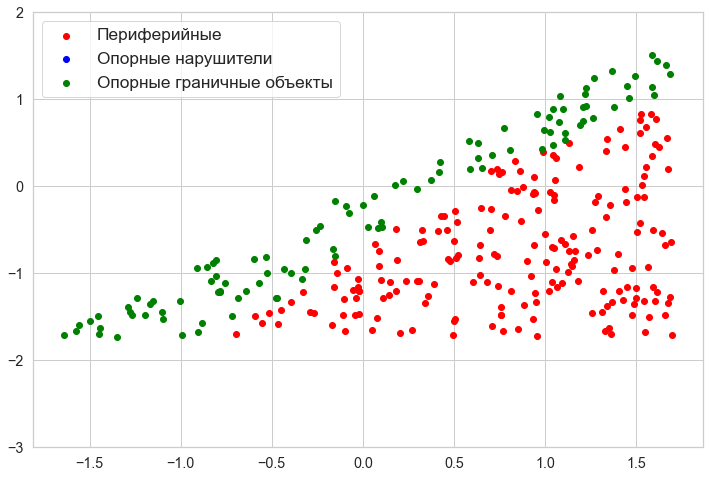

In [250]:
analyze_coefs('linear', 'default')

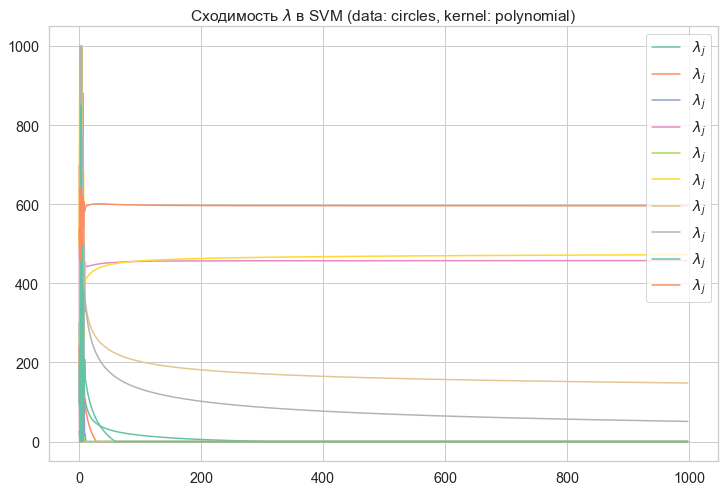

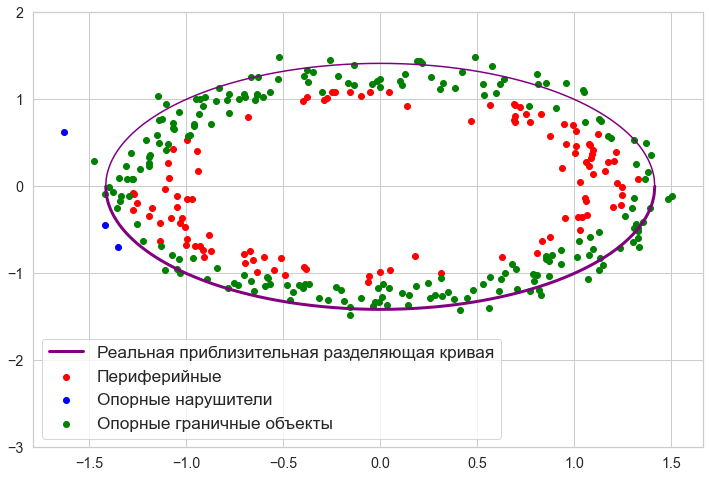

In [251]:
analyze_coefs('circles', 'polynomial')

В обоих случаях коэффициенты $\lambda_i$ сходятся, в случае линейно разделимой выборки опорных нарушителей не оказалось - это логично, мы генерировали датасет без выбросов.

На графике сходимости коэффициентов четко видны $\lambda_i$, сходящиеся к 0 - элементы, соответствующие этим $\lambda_i$ будут считаться периферийными и не будут оказывать влияния на работу модели.

Полученное распределение различных типов объектов в пространстве признаков также согласуется логикой: периферийные объекты оказываются в толще своего класса, опорные - ближе к границе раздела.

# Реализация SVM через оптимизацию прямой задачи

Оптимизируемый функционал:

$C \sum_{i=1}^l(1-M_i(w, w_0))_+ + \frac{1}{2}||w||^2 \rightarrow min_{w, w_0}$, где $M_i(w, w_0) = (\langle x_i, w \rangle-w_0)y_i$ - отступ (margin) объекта $x_i$

Предсказание для нового объекта $x$:

$a(x) = sign(\sum_{i=1}^{l}\lambda_i y_i \langle x, x_i \rangle - w_0)$

In [120]:
def f(w, X_train, y_train, C):
    assert(X_train.shape[1] == w.shape[0])
    assert(y_train.shape[0] == X_train.shape[0])
    return np.linalg.norm(w)**2 / 2 + C * (1 - min(y_train.dot(X_train @ w), 1))


def grad_f(w, X_train, y_train, C):
    assert(X_train.shape[1] == w.shape[0])
    assert(y_train.shape[0] == X_train.shape[0])
    filtered = (y_train * (X_train @ w) < 1)
    assert(filtered.shape == (X_train.shape[0],))
    answer = w - (C * X_train * y_train.reshape(-1, 1) * filtered.reshape(-1, 1)).sum(axis=0) / X_train.shape[0]
    return answer


def gradient_descent(f, gradf, x0, X_train, y_train, C, max_iter=1000, tol=1e-8,  rho=0.7, beta1=0.3):
    x = x0.copy()
    iteration = 0
    conv_array = []

    while True:
        beta2 = 1. -beta1
        alpha = 0.1 / (iteration + 1)
        gradient = gradf(x, X_train, y_train, C)
        x = x - alpha * gradient
        iteration += 1
        if np.linalg.norm(gradient) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)

    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradient),  "conv_array": np.array(conv_array)}
    return res


class SupportVectorMachineDirect:
    # Реализация SVM, оптимизирущая прямую, а не двойственную задачу
    
    def __init__(self, C=1000, fit_intercept=True, data_transformer=None):
        self.C = C
        self.fit_intercept = fit_intercept
        self.data_transformer = data_transformer
    
    @staticmethod
    def add_ones(X):
        return np.hstack([X.copy(), np.ones(shape=(X.shape[0], 1))])
    
    def fit(self, X_train, Y_train):
        if self.data_transformer is not None:
            X_train = self.data_transformer(X_train.copy())
        
        if self.fit_intercept:
            X_train = SupportVectorMachineDirect.add_ones(X_train)
        
        self.w = np.zeros(X_train.shape[1])
        res = gradient_descent(f, grad_f, self.w, X_train, Y_train, self.C)
        self.w = res['x']
        # Для построения графиков запоминаем, как сходились коэффициенты
        self.conv_array = res['conv_array']
        
    def predict(self, X_test):
        if self.data_transformer is not None:
            X_test = self.data_transformer(X_test.copy())
        
        if self.fit_intercept:
            X_test = SupportVectorMachineDirect.add_ones(X_test)
        
        return np.where(X_test @ self.w < 0, -1, 1)
    
    
    def get_accuracy(self, X_test, y_test):
        y_pred = self.predict(X_test)
        score = (y_pred == y_test).sum()
        return round(score / X_test.shape[0], 4)

In [121]:
def plot_classes(model, x_grid, y_grid):
    plt.figure(figsize=(12, 8))
    for x in x_grid:
        for y in y_grid:
            x_sample = np.array([x, y]).reshape(1, -1)
            res = model.predict(x_sample)[0]
            color = 'r' if res == 1 else 'b'
            plt.scatter(x, y, c=color)
    plt.show()

In [122]:
model = SupportVectorMachineDirect(data_transformer=polynomial_transformer, fit_intercept=True)
model.fit(X_circles_train, y_circles_train)

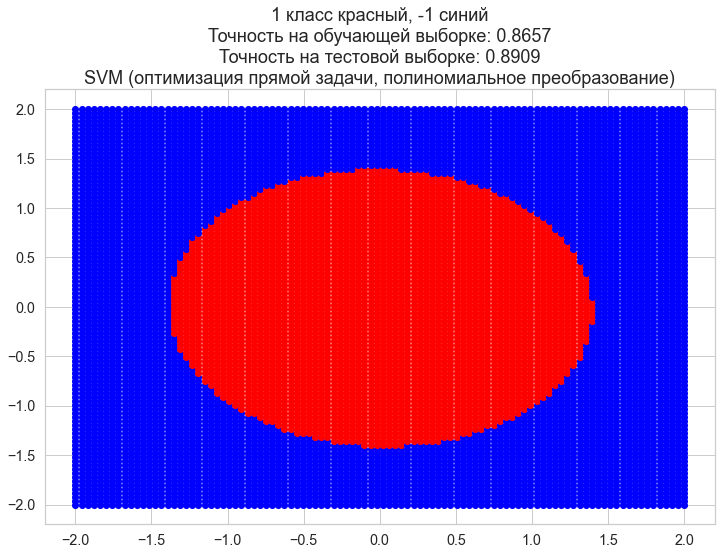

In [128]:
plt.figure(figsize=(12, 8))
x_grid = np.linspace(-2, 2, 100)
for x0 in x_grid:
    for x1 in x_grid:
        x_sample = np.array([x0, x1]).reshape(1, -1)
        y = model.predict(x_sample)[0]
        color = 'r' if y == 1 else 'b'
        plt.scatter(x0, x1, c=color)
title = '1 класс красный, -1 синий\n' +\
        f'Точность на обучающей выборке: {model.get_accuracy(X_circles_train, y_circles_train)}\n' +\
        f'Точность на тестовой выборке: {model.get_accuracy(X_circles_test, y_circles_test)}\n' +\
        'SVM (оптимизация прямой задачи, полиномиальное преобразование)'
plt.title(title, fontsize=18)
plt.show()

Как мы видим, решение прямой задачи также приводит к желаемому результату, точность классификации получается достаточно высокой 

# Выводы по работе

- SVM, использующий ядерный трюк - один из лучших методов бинарной классификации
- оба способа реализации SVM сходятся и дают неплохую точность (при использовании правильных ядер) на рассмотренных задачах
- переход к двойственной задаче в методе опорных векторов лучше тем, что позволяет обобщить метод на произвольные ядра

**Преимущества и проблемы SVM**

Преимущества:
- интерпретируемая и наглядная постановка исходной задачи
- задача выпуклого квадратичного программирования имеет единственное решение
- отбор элементов, важных для классификации позволяет хранить лишь часть исходной выборки
- обобщается на задачи регрессии и многоклассовой классификации

Проблемы:
- нет общих подходов к оптимизации $K(x, x')$ под задачу (но если подобрать его верно, как, например, полиномиальное ядро с датасетом hastie, то качество может оказаться очень хорошим)
- нет "встроенного" отбора признаков (для этого нужна L1 - регуляризация, например)
- нет общего способа подбирать константу $C$
- неустойчивость метода к шуму: выбросы в исходных данных становятся опорными объектами-нарушителями и могут оказывать влияние на модель

### Список использованной литературы
- https://en.wikipedia.org/wiki/Kernel_method
- R. Ravinder, Ramadevi Yellasiri, K.V.N. Sunitha: Anomaly Detection using Feature
Selection and SVM Kernel Trick, 2015
- Vorontsov School of Data Analysis Lecture May 2, 2020
- Varlam Kutateladze: The Kernel Trick for Nonlinear Factor Modeling
- The Annals of Statistics 2008, Vol. 36, No. 3, 1171–1220 (https://arxiv.org/pdf/math/0701907.pdf)
- Theodoridis, Sergios (2008). Pattern Recognition. Elsevier B.V. p. 203. ISBN 9780080949123.
- International Journal Of Computer Science And Applications Vol. 3, No. 2, July /
August 2010 Classifying Discriminant Features for Gender Determination